<a href="https://colab.research.google.com/github/adshre/Fast_AI_Practice/blob/master/DancerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *



     |████████████████████████████████| 727kB 2.8MB/s 
     |████████████████████████████████| 194kB 14.2MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 1.0MB 14.0MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 40kB 5.8MB/s 
     |████████████████████████████████| 92kB 8.1MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 2.6MB 17.0MB/s 
Mounted at /content/gdrive


In [ ]:
search_images_bing

<function fastbook.search_images_bing>

In [5]:
key = os.environ.get('AZURE_SEARCH_KEY', '9fc4593b8e36483ebd3a9209e0920531')
results = search_images_bing(key, 'bharatnatyam dancer')
ims = results.attrgot('content_url')
len(ims)

150

In [8]:
dest = '/bharatnatyam.jpg'
download_url(ims[0], dest)

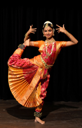

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

In [10]:
dancer_types = 'bharatnatyam','kathakali','ballet'
path = Path('dancers')

In [11]:
if not path.exists():
    path.mkdir()
    for o in dancer_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} dancers')
        download_images(dest, urls=results.attrgot('content_url'))

In [12]:
fns = get_image_files(path)
fns

(#447) [Path('dancers/kathakali/00000100.jpg'),Path('dancers/kathakali/00000055.jpg'),Path('dancers/kathakali/00000111.jpg'),Path('dancers/kathakali/00000136.jpg'),Path('dancers/kathakali/00000034.jpg'),Path('dancers/kathakali/00000062.jpg'),Path('dancers/kathakali/00000031.jpg'),Path('dancers/kathakali/00000027.jpg'),Path('dancers/kathakali/00000006.jpg'),Path('dancers/kathakali/00000007.jpg')...]

In [15]:
failed = verify_images(fns)
len(failed)
failed.map(Path.unlink);

In [16]:
dancers = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [17]:
dancers = dancers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dancers.dataloaders(path)

In [18]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.271197,0.427723,0.160920,01:29


epoch,train_loss,valid_loss,error_rate,time
0,0.459144,0.329014,0.103448,01:54
1,0.331668,0.259748,0.091954,01:53
2,0.245690,0.203621,0.045977,01:54
3,0.203064,0.169293,0.034483,01:53


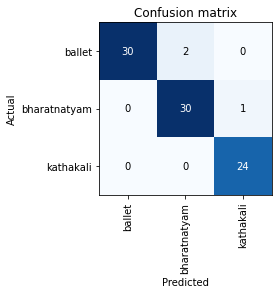

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

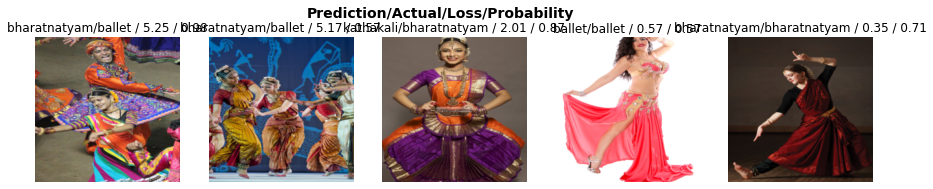

In [20]:
interp.plot_top_losses(5, nrows=1)

In [22]:
learn.export()

In [23]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [24]:
learn_inf = load_learner(path/'export.pkl')

In [25]:
learn_inf.predict('/bharatnatyam.jpg')

('bharatnatyam', tensor(1), tensor([9.9648e-07, 9.9999e-01, 1.1648e-05]))

In [26]:
learn_inf.dls.vocab

(#3) ['ballet','bharatnatyam','kathakali']

In [34]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [35]:
img = PILImage.create(btn_upload.data[-1])

In [36]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [37]:
pred,pred_idx,probs = learn_inf.predict(img)

In [38]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: bharatnatyam; Probability: 0.9693')

In [39]:
btn_run = widgets.Button(description='Classify')
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [40]:
btn_upload = widgets.FileUpload()

In [41]:
VBox([widgets.Label('Select your dancer!'), 
      btn_upload, btn_run, out_pl, lbl_pred])